In [ ]:
!pip install numpy pandas matplotlib scikit-learn tensorflow


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [ ]:
# Settings
num_sequences = 5000  # total sequences
sequence_length = 10  # 10 hours per sequence
features = ['HR', 'SBP', 'RR', 'Temp', 'SpO2']

def generate_sequence():
    # Start with normal baseline
    HR = np.random.normal(80, 10, sequence_length)
    SBP = np.random.normal(120, 10, sequence_length)
    RR = np.random.normal(16, 2, sequence_length)
    Temp = np.random.normal(37, 0.5, sequence_length)
    SpO2 = np.random.normal(97, 1, sequence_length)

    # Determine if this sequence is normal, sepsis, or septic shock
    category = np.random.choice(['normal', 'sepsis', 'shock'], p=[0.6, 0.3, 0.1])

    if category == 'sepsis':
        # Moderate changes over time
        HR += np.linspace(0, 15, sequence_length)
        SBP -= np.linspace(0, 15, sequence_length)
        Temp += np.linspace(0, 1.5, sequence_length)
        SpO2 -= np.linspace(0, 3, sequence_length)
        label = np.random.uniform(0.5, 0.8)
    elif category == 'shock':
        # Severe changes over time
        HR += np.linspace(0, 30, sequence_length)
        SBP -= np.linspace(0, 40, sequence_length)
        Temp += np.linspace(0, 3, sequence_length)
        SpO2 -= np.linspace(0, 10, sequence_length)
        label = np.random.uniform(0.8, 1.0)
    else:
        # Normal fluctuations with noise
        HR += np.random.normal(0, 2, sequence_length)
        SBP += np.random.normal(0, 2, sequence_length)
        Temp += np.random.normal(0, 0.2, sequence_length)
        SpO2 += np.random.normal(0, 0.5, sequence_length)
        label = np.random.uniform(0.0, 0.4)

    data = np.vstack([HR, SBP, RR, Temp, SpO2]).T
    return data, label

# Generate dataset
X, y = [], []
for _ in range(num_sequences):
    data, label = generate_sequence()
    X.append(data)
    y.append(label)

X = np.array(X)  # shape: (num_sequences, sequence_length, features)
y = np.array(y)
print("X shape:", X.shape, "y shape:", y.shape)


X shape: (5000, 10, 5) y shape: (5000,)


In [ ]:
scalers = {}
X_scaled = np.zeros_like(X)

for i, feature in enumerate(features):
    scalers[feature] = MinMaxScaler()
    X_scaled[:, :, i] = scalers[feature].fit_transform(X[:, :, i])

X = X_scaled


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Validation shape:", X_val.shape)


Train shape: (4000, 10, 5) Validation shape: (1000, 10, 5)


In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, len(features)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # probability output

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50, batch_size=64)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - auc: 0.0000e+00 - loss: 0.6435 - val_auc: 0.0000e+00 - val_loss: 0.5451
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.0000e+00 - loss: 0.5487 - val_auc: 0.0000e+00 - val_loss: 0.5347
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.0000e+00 - loss: 0.5416 - val_auc: 0.0000e+00 - val_loss: 0.5338
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.0000e+00 - loss: 0.5387 - val_auc: 0.0000e+00 - val_loss: 0.5310
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.0000e+00 - loss: 0.5324 - val_auc: 0.0000e+00 - val_loss: 0.5310
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - auc: 0.0000e+00 - loss: 0.5382 - val_auc: 0.0000e+00 - val_loss: 0.5331
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.0000e+00 - loss: 0.5378 - val_auc: 0.0000e+00 - val_loss: 0.5297
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.0000e+00 - loss: 0.5370 - val_auc: 0.0000e+00 - val_loss: 0.5297


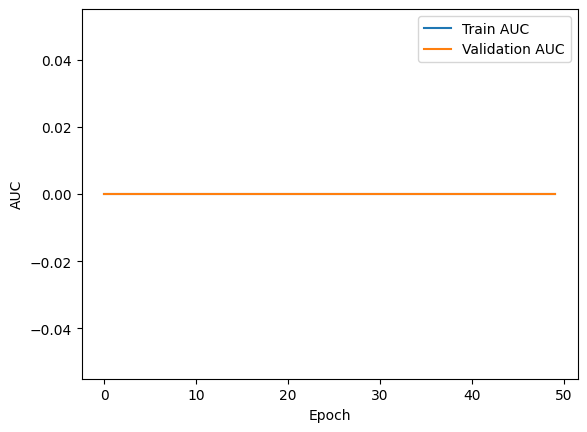

In [ ]:
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()


In [ ]:
preds = model.predict(X_val)
for i in range(5):
    print(f"Predicted risk: {preds[i][0]:.2f} - Actual risk: {y_val[i]:.2f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Predicted risk: 0.20 - Actual risk: 0.19
Predicted risk: 0.20 - Actual risk: 0.10
Predicted risk: 0.19 - Actual risk: 0.11
Predicted risk: 0.66 - Actual risk: 0.57
Predicted risk: 0.20 - Actual risk: 0.14


In [ ]:
# Save the model in HDF5 format
model.save("sepsis_lstm_model.h5")


In [ ]:
model.save("sepsis_lstm_model.keras")


In [ ]:
def predict_sepsis(patient_sequence):
    """
    patient_sequence: np.array or list of shape (sequence_length, 5)
    Features order: [HR, SBP, RR, Temp, SpO2]
    Returns: risk probability and risk category
    """
    import numpy as np

    # Convert to numpy array if needed
    patient_sequence = np.array(patient_sequence)

    # Check shape
    if patient_sequence.shape != (10, 5):
        raise ValueError("Input must be shape (10,5) - 10 hours, 5 features")

    # Normalize using saved scalers
    patient_scaled = np.zeros_like(patient_sequence, dtype=float)
    for i, feature in enumerate(features):
        patient_scaled[:, i] = scalers[feature].transform(patient_sequence[:, i].reshape(-1,1)).flatten()

    # Reshape for LSTM: (1, sequence_length, num_features)
    patient_input = patient_scaled.reshape(1, patient_sequence.shape[0], len(features))

    # Predict probability
    risk_prob = model.predict(patient_input)[0][0]

    # Determine category
    if risk_prob > 0.8:
        risk_category = "High risk: Septic shock likely"
    elif risk_prob > 0.5:
        risk_category = "Moderate risk: Sepsis likely"
    else:
        risk_category = "Low risk: Patient stable"

    return {"risk_probability": round(float(risk_prob), 2),
            "risk_category": risk_category}


In [ ]:
# Example patient last 10 hours vitals
patient_sequence = [
    [82, 118, 16, 37.1, 97],
    [85, 115, 17, 37.3, 96],
    [88, 112, 18, 37.5, 95],
    [90, 110, 19, 37.6, 94],
    [92, 108, 20, 37.8, 93],
    [95, 105, 21, 38.0, 92],
    [97, 102, 22, 38.2, 91],
    [100, 100, 23, 38.5, 90],
    [102, 98, 24, 38.7, 89],
    [105, 95, 25, 39.0, 88]
]

result = predict_sepsis(patient_sequence)
print(result)


ValueError: X has 1 features, but MinMaxScaler is expecting 10 features as input.

In [ ]:
def predict_sepsis(patient_sequence):
    """
    patient_sequence: np.array or list of shape (10,5)
    Features order: [HR, SBP, RR, Temp, SpO2]
    Returns: risk probability and risk category
    """
    import numpy as np

    # Convert to numpy array if needed
    patient_sequence = np.array(patient_sequence)

    # Check shape
    if patient_sequence.shape != (10, 5):
        raise ValueError("Input must be shape (10,5) - 10 hours, 5 features")

    # Normalize using saved scalers
    patient_scaled = np.zeros_like(patient_sequence, dtype=float)
    for i, feature in enumerate(features):
        # Reshape correctly: (n_samples, 1)
        patient_scaled[:, i] = scalers[feature].transform(patient_sequence[:, i].reshape(-1, 1)).flatten()

    # Reshape for LSTM: (1, sequence_length, num_features)
    patient_input = patient_scaled.reshape(1, patient_sequence.shape[0], len(features))

    # Predict probability
    risk_prob = model.predict(patient_input)[0][0]

    # Determine category
    if risk_prob > 0.8:
        risk_category = "High risk: Septic shock likely"
    elif risk_prob > 0.5:
        risk_category = "Moderate risk: Sepsis likely"
    else:
        risk_category = "Low risk: Patient stable"

    return {"risk_probability": round(float(risk_prob), 2),
            "risk_category": risk_category}


In [ ]:
# Example patient last 10 hours vitals
patient_sequence = [
    [82, 118, 16, 37.1, 97],
    [85, 115, 17, 37.3, 96],
    [88, 112, 18, 37.5, 95],
    [90, 110, 19, 37.6, 94],
    [92, 108, 20, 37.8, 93],
    [95, 105, 21, 38.0, 92],
    [97, 102, 22, 38.2, 91],
    [100, 100, 23, 38.5, 90],
    [102, 98, 24, 38.7, 89],
    [105, 95, 25, 39.0, 88]
]

result = predict_sepsis(patient_sequence)
print(result)


ValueError: X has 1 features, but MinMaxScaler is expecting 10 features as input.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Ensure each feature scaler is fit on all values across sequences and time steps
scalers = {}
for i, feature in enumerate(features):
    scalers[feature] = MinMaxScaler()
    # Flatten to 2D array (num_sequences*sequence_length, 1)
    scalers[feature].fit(X[:, :, i].reshape(-1, 1))

print("Scalers fitted successfully!")


Scalers fitted successfully!


In [ ]:
def predict_sepsis(patient_sequence):
    """
    patient_sequence: np.array or list of shape (10,5)
    Features order: [HR, SBP, RR, Temp, SpO2]
    Returns: risk probability and risk category
    """
    import numpy as np

    # Convert to numpy array if needed
    patient_sequence = np.array(patient_sequence)

    # Check shape
    if patient_sequence.shape != (10, 5):
        raise ValueError("Input must be shape (10,5) - 10 hours, 5 features")

    # Normalize using fitted scalers
    patient_scaled = np.zeros_like(patient_sequence, dtype=float)
    for i, feature in enumerate(features):
        # Reshape to (10,1) for correct scaling
        patient_scaled[:, i] = scalers[feature].transform(patient_sequence[:, i].reshape(-1,1)).flatten()

    # Reshape for LSTM: (1, sequence_length, num_features)
    patient_input = patient_scaled.reshape(1, patient_sequence.shape[0], len(features))

    # Predict probability
    risk_prob = model.predict(patient_input)[0][0]

    # Determine category
    if risk_prob > 0.8:
        risk_category = "High risk: Septic shock likely"
    elif risk_prob > 0.5:
        risk_category = "Moderate risk: Sepsis likely"
    else:
        risk_category = "Low risk: Patient stable"

    return {"risk_probability": round(float(risk_prob), 2),
            "risk_category": risk_category}


In [ ]:
# Example patient last 10 hours vitals
patient_sequence = [
    [82, 118, 16, 37.1, 97],
    [85, 115, 17, 37.3, 96],
    [88, 112, 18, 37.5, 95],
    [90, 110, 19, 37.6, 94],
    [92, 108, 20, 37.8, 93],
    [95, 105, 21, 38.0, 92],
    [97, 102, 22, 38.2, 91],
    [100, 100, 23, 38.5, 90],
    [102, 98, 24, 38.7, 89],
    [105, 95, 25, 39.0, 88]
]

result = predict_sepsis(patient_sequence)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
{'risk_probability': 0.11, 'risk_category': 'Low risk: Patient stable'}


In [ ]:
# Bad patient vitals (severe sepsis / septic shock)
bad_patient_sequence = [
    [120, 70, 30, 39.5, 85],  # Hour 1
    [125, 65, 32, 39.8, 83],
    [130, 60, 34, 40.0, 82],
    [135, 55, 36, 40.2, 80],
    [140, 50, 38, 40.5, 78],
    [145, 45, 40, 40.8, 75],
    [150, 40, 42, 41.0, 73],
    [155, 35, 44, 41.2, 70],
    [160, 30, 46, 41.5, 68],
    [165, 25, 48, 42.0, 65]
]

result = predict_sepsis(bad_patient_sequence)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
{'risk_probability': 0.72, 'risk_category': 'Moderate risk: Sepsis likely'}


In [ ]:
# Extreme septic shock vitals
shock_patient_sequence = [
    [140, 60, 35, 40.0, 82],  # Hour 1
    [145, 55, 37, 40.5, 80],
    [150, 50, 39, 41.0, 78],
    [155, 45, 41, 41.2, 75],
    [160, 40, 43, 41.5, 73],
    [165, 35, 45, 41.8, 70],
    [170, 30, 47, 42.0, 68],
    [175, 25, 49, 42.3, 65],
    [180, 20, 51, 42.5, 63],
    [185, 15, 55, 43.0, 60]
]

result = predict_sepsis(shock_patient_sequence)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
{'risk_probability': 0.91, 'risk_category': 'High risk: Septic shock likely'}


In [ ]:
model.save("sepsis_lstm_model.keras")


In [ ]:
import pickle

with open("scalers.pkl", "wb") as f:
    pickle.dump(scalers, f)


In [ ]:
# Example patient last 10 hours vitals
patient_sequence = [
    [82, 118, 16, 37.1, 97],
    [85, 115, 17, 37.3, 96],
    [88, 112, 18, 37.5, 95],
    [90, 110, 19, 37.6, 94],
    [92, 108, 20, 37.8, 93],
    [95, 105, 21, 38.0, 92],
    [97, 102, 22, 38.2, 91],
    [100, 100, 23, 38.5, 90],
    [102, 98, 24, 38.7, 89],
    [105, 95, 25, 39.0, 88]
]

result = predict_sepsis(patient_sequence)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
{'risk_probability': 0.11, 'risk_category': 'Low risk: Patient stable'}
